In [16]:
import os
import muda
import csv
import scipy
import numpy as np

In [17]:
def PNCC(y,sr,parameters):
    '''
    Calculate the
        MFCCs : Mel-frequency cepstral coefficients (MFCCs)
        PCENs : using PCEN() to replace the log amplitude (dB) scaling on Mel spectra
    '''
    win_size = parameters['win_size']
    hop_size = parameters['hop_size']
    n_mels = parameters['num_mel_filters']
    n_dct = parameters['n_dct']
    fmin = parameters['min_freq']
    fmax = parameters['max_freq']
    mel_spectrogram = librosa.feature.melspectrogram(y=y, 
                                                    sr=sr,
                                                    n_fft=win_size, 
                                                    hop_length=hop_size, 
                                                    power=1, 
                                                    n_mels= n_mels)
    
    S_PNCC = librosa.pcen(mel_spectrogram * (2**31))
    #S_PNCC = librosa.pcen(mel_spectrogram * (2**31), gain=0.8, bias=10,
                               #power=0.25, time_constant=0.06)
    return scipy.fftpack.dct(S_PNCC, axis=0, type=2, norm='ortho')[:n_dct]
#================================================================================================
def FeatureExtraction(FilePath,Parameters):
    sr = Parameters['sampling_rate']
    win_size =  Parameters['win_size']
    hop_size = Parameters['hop_size']

    audio_data,audio_sr = librosa.load(FilePath,sr, mono = True)

    #Other Features might be used========================================================
    #audio_mag = np.abs(librosa.stft(audio_data, n_fft=win_size, hop_length=hop_size)) 
    #Short Time Energy
    #ste = ShortTimeEnergy(signal=audio_data,win_size=win_size,hop_size=hop_size)
        #ZCR
    #zcr = librosa.feature.zero_crossing_rate(y=audio_data,frame_length=win_size,hop_length=hop_size)
        #Spectral Centroid
    #cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr,n_fft=win_size, hop_length=hop_size)
        #Spectral Entropy
    #entropy = Spectral_Entropy(y_Mag=audio_mag,sr=sr,n_short_blocks=10)
        #MFCCs and MFCCs with PCEN scaling
    #mfccs, pcens = PCEN_MFCC(y=audio_data,sr=sr,parameters=Parameters)
    #mfccs = librosa.feature.mfcc(y=audio_data, n_fft=win_size, hop_length=hop_size, sr=sr, n_mfcc=20, dct_type=2, norm='ortho')
    pnccs = PNCC(y=audio_data, sr=sr, parameters = Parameters)
    #Flatten all the feature matrix and concatenate them into a 1D vector
    #feature_vector = np.concatenate((mfccs,pnccs), axis = 0)
    return pnccs, audio_data, audio_sr
#================================================================================================
def CreateLabelVector(Data,EventList,Parameters,LabelIndex=1):
    #Given audio data, event list, create its corresponding label vector with given index
    #list for saving number of frame labels. 
    hop_size = Parameters['hop_size']
    audio_sr = Parameters['sampling_rate']
    label_vector = np.zeros(int(np.ceil(len(Data)/hop_size)))                      
    for event in EventList:
        osnet_frame = np.ceil(event['onset'] * audio_sr/hop_size).astype(int)
        offset_frame = np.floor(event['offset'] * audio_sr/hop_size).astype(int)
        label_vector[osnet_frame:offset_frame] = LabelIndex
    return label_vector.astype(int)

def ComputeStateTransition(LabelVector):
        #Calculate the probability of status transition If data contains speech 
        ee_temp = 0 # num of event to event
        nn_temp = 0 # num of none to none
        en_temp = 0 # num of event to none
        ne_temp = 0 # num of none to event
        previous_e = 0 # num of frames with previous is event
        previous_n = 0 # num of frames with previous is none
        if sum(LabelVector) != 0:
            for frame_index in range(len(LabelVector)-1):
                if LabelVector[frame_index] == 0 and LabelVector[frame_index+1] > LabelVector[frame_index]:
                    previous_n = previous_n + 1
                    ne_temp = ne_temp + 1
                elif LabelVector[frame_index] == 0 and LabelVector[frame_index+1] == LabelVector[frame_index]:
                    previous_n = previous_n + 1
                    nn_temp = nn_temp + 1
                elif LabelVector[frame_index] == 1 and LabelVector[frame_index+1] < LabelVector[frame_index]:
                    previous_e = previous_e + 1
                    en_temp = en_temp + 1
                elif LabelVector[frame_index] == 1 and LabelVector[frame_index+1] == LabelVector[frame_index]:
                    previous_e = previous_e + 1
                    ee_temp = ee_temp + 1
            #compute the probability        
            p_ee = ee_temp/previous_e
            p_nn = nn_temp/previous_n
            p_en = en_temp/previous_e
            p_ne = ne_temp/previous_n
        return p_ee,p_nn,p_en,p_ne
#=================================================================================================================
def CreateDataset(Files_Dir,Parameters,Property,EventLabel='speech'):
    #Process all the .wav, .txt, in the assigned folder
    
    #Files_Dir: Target folder for saving all raw audio data
    #Parameters: Using  for processing audio files
    #Property:Create train/test set?
    #EventLabel: The label in string which indicate the class you want to learn

    data = []
    labels = []
    
    #Calculate the Transition Matrix From Training set,saving the probability of each status transition
    SS = []#Speech to Speech
    NN = []#NonSpeech to NonSpeech
    SN = []#Speech to NonSpeech
    NS = []#NonSpeech to Speech
    
    file_index = 1
    group = []
    for root, dirs,files in os.walk(Files_Dir):
        #.txt-based: which means processing txt first then find its corresponding .wav file
        
        #root_path,subfolders = root,dirs
        for file in os.listdir(root):   
            if file.endswith('.txt'):  
                print('Processing file.{} for {} set'.format(file_index,Property))
                file_path = root + '/' + file
                processed_filename =  os.path.splitext(file)[0]
                #Load Annotated Information
                annotated_event = sed_eval.io.load_event_list(file_path)
                target_event = sed_eval.util.event_list.filter_event_list(annotated_event, scene_label=None, event_label=EventLabel, filename=None)

                #Load Audio for feature extraction
                audio_file_name = os.path.splitext(file)[0] + '.wav'
                audio_file_path = root + '/' + audio_file_name             
                feature_vector,audio_data, audio_sr = FeatureExtraction(audio_file_path,Parameters)

                #Using Annotation info to create the vector labels
                label_vector = CreateLabelVector(Data=audio_data,
                                                     EventList=target_event,
                                                     Parameters=Parameters,
                                                     LabelIndex=1)    
                if feature_vector.shape[1] != len(label_vector):
                    print('===========Waring! Unmatched data size,will skip this file:==========')
                    print(file_path)
                    continue

                #Calculate the probability in the transition state matrix If data contains speech 
                if sum(label_vector) != 0:
                    #probability of ss,nn,sn,ns; n=nonspeech, s = speech
                    p_ss, p_nn, p_sn, p_ns = ComputeStateTransition(label_vector)                
                    SS.append(p_ss)
                    NN.append(p_nn)
                    SN.append(p_sn)
                    NS.append(p_ns)
                #create group list
                temp_group = np.ones(len(label_vector))*file_index
                group = group + temp_group.astype(int).tolist()
                
                data.append([feature_vector,label_vector])
                file_index += 1
    
    #Transition Matrix:
    trans_matrix = np.array([[np.mean(SS),1 - np.mean(SS)],[1 - np.mean(NN),np.mean(NN)]])
    #Saving the transition Matrix
    np.save(os.getcwd()+'/JPNotebookExported/' + Property + '_TransitionMatrix.npy', trans_matrix)
    np.save(os.getcwd()+'/JPNotebookExported/' + Property + '_Dataset.npy', np.asarray(data))
    #Saving group info
    np.save(os.getcwd()+'/JPNotebookExported/' + Property + '_GroupK.npy', np.asarray(group))
    print(trans_matrix)
    
    return np.asarray(data),trans_matrix

In [26]:

def DeformDataset(DatasetPath,OutputPath,DeformerBook):
    for item in DeformerBook:
        #Create directory for saving deformed dataset(original dataset excluded)
        dirName = OutputPath + '/' + item
        os.mkdir(dirName)
        deformer = DeformerBook[item]
        for root, dirs,files in os.walk(DatasetPath):
            for file in os.listdir(root):  
                if file.endswith(".jams"):
                    file_name = os.path.splitext(file)[0]

                    jams_path = root + '/' + file_name + '.jams'
                    audio_path = root + '/' + file_name + '.wav'

                    output_path = dirName + '/' + file_name
                    # Load an example audio file with annotation
                    print(jams_path)
                    print(audio_path)
                    j_orig = muda.load_jam_audio(jams_path, audio_path)            
                    mudabox = j_orig.sandbox.muda
                    #if len(mudabox._audio["y"]) != 220500:
                        #break
                    #for j_new in pipeline.transform(j_orig):
                        #print(j_new)
                    for i, jam_out in enumerate(deformer.transform(j_orig)):
                        muda.save(output_path + '_deformed_{:02d}.wav'.format(i),
                                   output_path + '_deformed_{:02d}.jams'.format(i),
                                   jam_out)

                        #load scaper annotations
                        ann = jam_out.annotations.search(namespace='scaper')[0]
                        #Write new txt file
                        txt_path = output_path + '_deformed_{:02d}.txt'.format(i)
                        csv_data = []
                        for obs in ann.data:
                            if obs.value['role'] == 'foreground':
                                csv_data.append(
                                    [obs.time, obs.time+obs.duration, obs.value['label']])

                        with open(txt_path, 'w') as csv_file:
                            writer = csv.writer(csv_file, delimiter='\t')
                            writer.writerows(csv_data)

In [48]:
ir_files_path = os.getcwd() + '/1_Dataset_Generate/audio/IR_greathall/sample.wav'
# initialize deformer object
#pitch_shift_1 = muda.deformers.PitchShift(n_semitones=-1)
#pitch_shift_2 = muda.deformers.PitchShift(n_semitones=1)
pitch_shift = muda.deformers.RandomPitchShift(n_samples=1, mean=0.0, sigma=1.0)
time_stretch = muda.deformers.RandomTimeStretch(n_samples=1,scale=0.3)
colored_noise = muda.deformers.ColoredNoise(n_samples=1,color=['brownian'],weight_min=0.1, weight_max=0.9)
drc = muda.deformers.DynamicRangeCompression(preset='speech')
ir_convolution = muda.deformers.IRConvolution(ir_files = ir_files_path, n_fft=1024, rolloff_value=-24)

#setup the directory of dataset
dataset_dir = os.getcwd() + '/1_Dataset_Generate/audio/soundbanks/train/generated'
OutputPath = os.getcwd() + '/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline'

#deformers = {#'PitchShift':pitch_shift,
#             'TimeStretched':time_stretch,
             #'IRConvolution':ir_convolution,
             #'ColoredNoise':colored_noise,
             #'DynamicCompressed':drc
#}
    
#DeformDataset(DatasetPath = dataset_dir,OutputPath = output_dir,DeformerBook = deformers)   
pipeline = muda.Pipeline(steps=[('pitch_shift', pitch_shift),
                                ('time_stretch', time_stretch),
                                ('drc', drc),
                                ('colored_noise', colored_noise),
                                ('ir', ir_convolution)
                               ])

dirName = OutputPath + '/PTDCI'
for root, dirs,files in os.walk(dataset_dir):
    for file in os.listdir(root):  
        if file.endswith(".jams"):
            file_name = os.path.splitext(file)[0]

            jams_path = root + '/' + file_name + '.jams'
            audio_path = root + '/' + file_name + '.wav'

            output_path = dirName + '/' + file_name
            # Load an example audio file with annotation
            print(jams_path)
            print(audio_path)
            j_orig = muda.load_jam_audio(jams_path, audio_path)            
            mudabox = j_orig.sandbox.muda
            #if len(mudabox._audio["y"]) != 220500:
                #break
            #for j_new in pipeline.transform(j_orig):
                #print(j_new)
            print(output_path)
            for i, jam_out in enumerate(pipeline.transform(j_orig)):
                muda.save(output_path + '_deformed_{:02d}.wav'.format(i),
                           output_path + '_deformed_{:02d}.jams'.format(i),
                           jam_out)

                #load scaper annotations
                ann = jam_out.annotations.search(namespace='scaper')[0]
                #Write new txt file
                txt_path = output_path + '_deformed_{:02d}.txt'.format(i)
                csv_data = []
                for obs in ann.data:
                    if obs.value['role'] == 'foreground':
                        csv_data.append(
                            [obs.time, obs.time+obs.duration, obs.value['label']])

                with open(txt_path, 'w') as csv_file:
                    writer = csv.writer(csv_file, delimiter='\t')
                    writer.writerows(csv_data)

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1196.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1196.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1196
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1895.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1895.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1895
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1591.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1591.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1591
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1084.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1084.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1084
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1138.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1138.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1138
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform608.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform608.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform608
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1246.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1246.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1246
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform576.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform576.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform576
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1401.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1401.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1401
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform32.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform32.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform32
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1285.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1285.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1285
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform65.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform65.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform65
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1339.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1339.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1339
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1786.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1786.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1786
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform53.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform53.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform53
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform583.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform583.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform583
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/so

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform184.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform184.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform184
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform887.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform887.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform887
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1358.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1358.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1358
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform468.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform468.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform468
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1026.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1026.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1026
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform716.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform716.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform716
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1661.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1661.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1661
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform782.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform782.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform782
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform805.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform805.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform805
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform385.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform385.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform385
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1159.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1159.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1159
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform686.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform686.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform686
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform280.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform280.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform280
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform900.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform900.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform900
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform404.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform404.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform404
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1334.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1334.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1334
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform412.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform412.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform412
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform107.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform107.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform107
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1230.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1230.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1230
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform500.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform500.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform500
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform44.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform44.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform44
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform594.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform594.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform594
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/so

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform469.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform469.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform469
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1436.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1436.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1436
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform701.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform701.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform701
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1031.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1031.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1031
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1380.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1380.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1380
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1800.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1800.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1800
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform664.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform664.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform664
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1154.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1154.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1154
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1142.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1142.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1142
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform672.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform672.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform672
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1953.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1953.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1953
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1050.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1050.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1050
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1181.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1181.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1181
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1494.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1494.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1494
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform609.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform609.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform609
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1656.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1656.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1656
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1251.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1251.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1251
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1601.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1601.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1601
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform706.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform706.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform706
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1036.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1036.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1036
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1431.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1431.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1431
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform301.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform301.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform301
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1974.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1974.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1974
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1831.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1831.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1831
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform710.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform710.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform710
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform205.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform205.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform205
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1958.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1958.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1958
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform291.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform291.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform291
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform950.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform950.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform950
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform403.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform403.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform403
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform907.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform907.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform907
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform842.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform842.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform842
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1606.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1606.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1606
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform136.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform136.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform136
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform161.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform161.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform161
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform531.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform531.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform531
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1352.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1352.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1352
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform462.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform462.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform462
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1755.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1755.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1755
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1305.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1305.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1305
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1391.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1391.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1391
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform225.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform225.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform225
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform399.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform399.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform399
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform663.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform663.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform663
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1807.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1807.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1807
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1942.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1942.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1942
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1555.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1555.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1555
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform265.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform265.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform265
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1502.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1502.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1502
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform232.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform232.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform232
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1902.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1902.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1902
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform361.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform361.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform361
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1406.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1406.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1406
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1955.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1955.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1955
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform208.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform208.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform208
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1538.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1538.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1538
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1650.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1650.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1650
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform160.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform160.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform160
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform137.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform137.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform137
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform834.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform834.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform834
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1735.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1735.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1735
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform455.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform455.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform455
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform547.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform547.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform547
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1277.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1277.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1277
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1631.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1631.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1631
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform81.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform81.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform81
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1888.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1888.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1888
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1922.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1922.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1922
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform746.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform746.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform746
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform316.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform316.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform316
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform750.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform750.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform750
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1060.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1060.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1060
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1871.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1871.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1871
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1488.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1488.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1488
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform840.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform840.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform840
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform905.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform905.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform905
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform401.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform401.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform401
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1761.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1761.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1761
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform339.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform339.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform339
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform293.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform293.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform293
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1167.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1167.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1167
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1188.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1188.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1188
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform745.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform745.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform745
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1075.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1075.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1075
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1433.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1433.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1433
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1599.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1599.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1599
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1464.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1464.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1464
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform587.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform587.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform587
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1805.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1805.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1805
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform266.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform266.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform266
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1151.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1151.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1151
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform661.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform661.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform661
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform677.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform677.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform677
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1147.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1147.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1147
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1813.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1813.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1813
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform964.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform964.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform964
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform899.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform899.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform899
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform933.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform933.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform933
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform499.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform499.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform499
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform163.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform163.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform163
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1604.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1604.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1604
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1487.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1487.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1487
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform973.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform973.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform973
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform836.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform836.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform836
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform532.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform532.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform532
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform861.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform861.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform861
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform174.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform174.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform174
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1490.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1490.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1490
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1404.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1404.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1404
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform334.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform334.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform334
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1003.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1003.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1003
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1900.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1900.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1900
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform230.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform230.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform230
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1500.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1500.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1500
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform267.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform267.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform267
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1557.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1557.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1557
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1520.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1520.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1520
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1873.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1873.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1873
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1598.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1598.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1598
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1062.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1062.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1062
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1977.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1977.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1977
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform744.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform744.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform744
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1023.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1023.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1023
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1920.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1920.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1920
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform103.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform103.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform103
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1799.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1799.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1799
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1625.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1625.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1625
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1330.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1330.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1330
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1737.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1737.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1737
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1367.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1367.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1367
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform260.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform260.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform260
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1550.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1550.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1550
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform237.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform237.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform237


/Users/anderson675/miniconda3/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1507.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1507.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1507
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1792.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1792.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1792
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1842.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1842.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1842
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1395.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1395.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1395
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1301.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1301.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1301
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform962.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform962.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform962
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1706.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1706.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1706
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform523.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform523.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform523
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1655.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1655.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1655
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1205.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1205.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1205
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform831.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform831.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform831
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1481.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1481.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1481
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform450.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform450.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform450
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform903.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform903.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform903
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform692.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform692.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform692
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1458.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1458.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1458
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1233.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1233.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1233
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1399.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1399.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1399
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1024.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1024.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1024
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform47.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform47.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform47
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1970.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1970.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1970
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform10.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform10.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform10
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform186.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform186.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform186
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1209.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1209.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1209
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform51.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform51.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform51
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform978.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform978.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform978
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/so

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform884.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform884.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform884
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform187.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform187.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform187
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform11.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform11.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform11
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform191.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform191.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform191
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/so

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform579.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform579.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform579
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1249.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1249.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1249
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1662.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1662.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1662
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform152.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform152.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform152
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1320.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1320.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1320
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform943.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform943.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform943
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1766.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1766.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1766
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform685.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform685.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform685
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform797.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform797.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform797
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1480.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1480.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1480
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform758.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform758.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform758
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform308.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform308.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform308
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform467.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform467.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform467
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1357.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1357.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1357
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform430.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform430.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform430
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1300.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1300.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1300
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform277.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform277.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform277
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1394.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1394.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1394
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1269.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1269.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1269
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1639.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1639.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1639
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1290.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform1290.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform1290
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform959.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform959.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform959
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform27.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/uniform/soundscape_train_uniform27.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_uniform27
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1473.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1473.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1473
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1074.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1074.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1074
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal315.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal315.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal315
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1062.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1062.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1062
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1598.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1598.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1598
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1465.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1465.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1465
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1170.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1170.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1170
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1737.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1737.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1737
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal456.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal456.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal456
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1760.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1760.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1760
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal952.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal952.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal952
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal102.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal102.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal102
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1263.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1263.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1263
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal155.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal155.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal155
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1664.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1664.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1664
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1214.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1214.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1214
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal175.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal175.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal175
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1202.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1202.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1202
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal533.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal533.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal533
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal421.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal421.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal421
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1740.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1740.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1740
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1107.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1107.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1107
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1412.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1412.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1412
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal62.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal62.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal62
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1916.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1916.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1916
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal362.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal362.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal362
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1003.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1003.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1003
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1054.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1054.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1054
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal335.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal335.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal335
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1239.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1239.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1239
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal508.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal508.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal508
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1151.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1151.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1151
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal660.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal660.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal660
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1805.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1805.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1805
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal267.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal267.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal267
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal709.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal709.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal709
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1891.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1891.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1891
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal498.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal498.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal498
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal162.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal162.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal162
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1215.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1215.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1215
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal174.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal174.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal174
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal965.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal965.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal965
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1757.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1757.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1757
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal768.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal768.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal768
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal945.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal945.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal945
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal400.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal400.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal400
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1761.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1761.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1761
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1366.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1366.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1366
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1673.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1673.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1673
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal705.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal705.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal705
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1034.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1034.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1034
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1599.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1599.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1599
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1960.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1960.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1960
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal314.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal314.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal314
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1425.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1425.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1425
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1864.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1864.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1864
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal206.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal206.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal206
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal348.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal348.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal348
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1880.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1880.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1880
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal165.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal165.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal165
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1654.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1654.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1654
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1603.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1603.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1603
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal132.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal132.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal132
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1551.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1551.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1551
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal260.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal260.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal260
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal237.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal237.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal237
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1506.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1506.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1506
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal72.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal72.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal72
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1843.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1843.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1843
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal763.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal763.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal763
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1402.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1402.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1402
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal128.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal128.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal128
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal981.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal981.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal981
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1967.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1967.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1967
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal305.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal305.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal305
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal186.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal186.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal186
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1033.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1033.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1033
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal283.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal283.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal283
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal779.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal779.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal779
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal954.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal954.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal954
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal407.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal407.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal407
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1770.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1770.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1770
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1320.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1320.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1320
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal503.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal503.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal503
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1662.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1662.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1662
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal294.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal294.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal294
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1771.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1771.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1771
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal955.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal955.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal955
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal406.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal406.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal406
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal902.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal902.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal902
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal847.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal847.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal847
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal353.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal353.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal353
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1198.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1198.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1198
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1435.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1435.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1435
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal754.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal754.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal754
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal312.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal312.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal312
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1970.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1970.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1970
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1531.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1531.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1531
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal200.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal200.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal200
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1680.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1680.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1680
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal918.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal918.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal918
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1638.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1638.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1638
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal109.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal109.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal109
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal261.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal261.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal261
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1100.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1100.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1100
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1481.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1481.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1481
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal49.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal49.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal49
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1086.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1086.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1086
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal867.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal867.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal867
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1643.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1643.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1643
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal172.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal172.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal172
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1244.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1244.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1244
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1751.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1751.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1751
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1379.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1379.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1379
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal448.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal448.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal448
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1912.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1912.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1912
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal89.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal89.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal89
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1416.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1416.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1416
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal777.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal777.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal777
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal649.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal649.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal649
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1197.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1197.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1197
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1713.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1713.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1713
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1343.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1343.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1343
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1705.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1705.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1705
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal937.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal937.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal937
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal576.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal576.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal576
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1247.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1247.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1247
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal106.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal106.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal106
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1637.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1637.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1637
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1621.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1621.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1621
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal110.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal110.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal110
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal901.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal901.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal901
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1733.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1733.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1733
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal46.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal46.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal46
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1932.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1932.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1932
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal307.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal307.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal307
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1436.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1436.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1436
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal741.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal741.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal741
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1420.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1420.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1420
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal51.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal51.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal51
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1860.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1860.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1860
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1564.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1564.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1564
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1837.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1837.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1837
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1122.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1122.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1122
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal613.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal613.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal613
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1899.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1899.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1899
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1030.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1030.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1030
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal900.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal900.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal900
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1732.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1732.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1732
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1335.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1335.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1335
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1765.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1765.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1765
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal296.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal296.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal296
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal783.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal783.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal783
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1303.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1303.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1303
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal432.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal432.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal432
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1641.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1641.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1641
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal170.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal170.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal170
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal865.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal865.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal865
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1084.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1084.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1084
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal648.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal648.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal648
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1483.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1483.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1483
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal633.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal633.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal633
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1786.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1786.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1786
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal808.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal808.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal808
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1790.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1790.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1790
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1682.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1682.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1682
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal449.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal449.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal449
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal911.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal911.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal911
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1373.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1373.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1373
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal95.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal95.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal95
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal7.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal7.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal7
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundban

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal83.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal83.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal83
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal680.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal680.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal680
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/so

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal585.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal585.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal585
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal839.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal839.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal839
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal478.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal478.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal478
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1719.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1719.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1719
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1830.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1830.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1830
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1133.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1133.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1133
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal655.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal655.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal655
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1164.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1164.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1164
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal622.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal622.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal622
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal788.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal788.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal788
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1847.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1847.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1847
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1797.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1797.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1797
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal819.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal819.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal819
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1781.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1781.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1781
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1739.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1739.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1739
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1484.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1484.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1484
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1579.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1579.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1579
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1083.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1083.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1083
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal198.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal198.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal198
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1353.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1353.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1353
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1304.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1304.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1304
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal966.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal966.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal966
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1169.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1169.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1169
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1493.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1493.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1493
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1997.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1997.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1997
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1978.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1978.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1978
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1597.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1597.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1597
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal971.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal971.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal971
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1692.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1692.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1692
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1738.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1738.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1738
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal377.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal377.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal377
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1446.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1446.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1446
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal361.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal361.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal361
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1000.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1000.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1000
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal20.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal20.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal20
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1112.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1112.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1112
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1309.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1309.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1309
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal438.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal438.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal438
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal879.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal879.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal879
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal480.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal480.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal480
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal496.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal496.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal496
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1870.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1870.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1870
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal639.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal639.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal639
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1558.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1558.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1558
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1276.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1276.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1276
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal117.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal117.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal117
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1630.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1630.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1630
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal101.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal101.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal101
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal443.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal443.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal443
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1688.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/bimodal/soundscape_train_bimodal1688.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_bimodal1688
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/au

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1576
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1126.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1126.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1126
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal648.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal648.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1560
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1075.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1075.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1075
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1425.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1425.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1472
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1188.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1188.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1188
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1022.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1022.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1665
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1370.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1370.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1370
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1720.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1720.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1018
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal633.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal633.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal633
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal263.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal263.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1673
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1389.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1389.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1389
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1223.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1223.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal756
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1891.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1891.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1891
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal306.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal306.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1080
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1595.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1595.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1595
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal351.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal351.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1429
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1079.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1079.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1079
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1583.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1583.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal740
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal557.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal557.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal557
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal107.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal107.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gene

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1540
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1794.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1794.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1794
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal853.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal853.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal516
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal146.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal146.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal146
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1628.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1628.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1385
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal111.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal111.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal111
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal9.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal9.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generat

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal85
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1941.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1941.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1941
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal686.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal686.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal956
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1015.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1015.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1015
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1445.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1445.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal297
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1900.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1900.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1900
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1453.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1453.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1404
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal690.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal690.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal690
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1957.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1957.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal254
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal604.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal604.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal604
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1490.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1490.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal203
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal50.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal50.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal50
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal716.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal716.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generat

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal645
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1081.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1081.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1081
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1594.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1594.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal307
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1469.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1469.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1469
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1193.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1193.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal409
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal370.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal370.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal370
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal720.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal720.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gene

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal262
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal798.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal798.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal798
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal31.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal31.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Genera

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1371
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1721.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1721.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1721
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal736.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal736.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal258
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1865.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1865.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1865
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1920.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1920.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1074
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1424.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1424.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1424
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1977.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1977.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal921
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal472.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal472.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal472
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal188.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal188.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gene

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal183
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal496.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal496.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal496
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1252.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1252.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal838
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1205.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1205.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1205
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1086.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1086.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal984
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1993.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1993.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1993
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal654.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal654.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1497
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal253.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal253.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal253
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal603.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal603.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal94
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1053.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1053.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1053
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1403.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1403.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1454
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1004.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1004.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1004
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal290.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal290.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1442
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1157.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1157.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1157
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1507.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1507.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal82
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal681.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal681.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal681
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1946.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1946.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal863
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal530.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal530.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal530
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal160.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal160.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gene

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1136
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1566.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1566.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1566
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal208.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal208.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1474
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1024.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1024.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1024
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1927.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1927.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1233
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1663.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1663.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1663
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1399.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1399.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1321
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal770.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal770.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal770
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal320.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal320.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal61
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal662.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal662.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal662
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal398.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal398.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gener

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1418
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal233.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal233.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal233
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal60.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal60.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gener

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal858
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1265.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1265.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1265
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1770.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1770.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal730
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal99.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal99.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal99
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal360.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal360.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generat

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1475
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1025.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1025.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1025
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1926.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1926.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal970
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal589.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal589.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal589
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal423.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal423.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gene

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal531
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal161.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal161.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal161
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1176.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1176.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1551
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1101.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1101.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1101
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal116.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal116.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1855
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal792.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal792.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal792
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal638.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal638.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal157
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal507.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal507.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal507
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1269.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1269.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal679
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal383.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal383.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal383
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1394.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1394.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal194
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal897.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal897.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal897
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1750.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1750.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1707
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal593.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal593.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal593
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal439.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal439.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1341
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1654.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1654.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1654
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal993.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal993.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal182
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal497.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal497.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal497
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1253.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1253.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal816
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1381.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1381.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1381
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal115.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal115.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal512
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal142.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal142.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal142
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1786.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1786.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1790
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal154.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal154.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal154
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal504.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal504.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal553
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal103.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal103.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal103
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1397.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1397.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1753
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1303.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1303.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1303
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal197.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal197.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1354
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1704.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1704.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1704
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1591.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1591.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal586
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1895.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1895.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1895
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal752.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal752.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal882
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1732.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1732.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1732
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1362.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1362.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1270
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1620.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1620.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1620
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1509.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1509.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal22
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal621.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal621.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal621
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1909.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1909.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal877
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal174.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal174.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal174
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal524.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal524.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gene

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1708
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1358.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1358.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1358
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal965.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal965.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1964
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1437.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1437.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1437
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1067.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1067.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1899
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1876.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1876.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1876
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal18.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal18.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1318
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal925.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal925.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal925
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal476.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal476.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1420
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1973.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1973.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1973
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1836.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1836.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1532
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1162.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1162.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1162
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1498.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1498.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal948
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1375.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1375.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1375
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1725.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1725.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1508
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1158.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1158.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1158
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal636.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal636.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal724
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1733.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1733.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1733
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1363.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1363.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1894
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal303.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal303.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal303
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1197.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1197.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1969
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal354.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal354.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal354
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal704.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal704.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1569
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1093.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1093.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1093
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1139.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1139.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal315
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1882.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1882.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1882
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal745.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal745.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1115
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1545.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1545.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1545
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1050.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1050.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal769
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal293.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal293.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal293
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal339.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal339.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gene

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1154
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1504.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1504.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1504
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1011.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1011.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal81
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal378.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal378.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal378
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal682.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal682.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gener

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal689
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal723.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal723.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal723
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1333.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1333.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Ge

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1630
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1260.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1260.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1260
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1149.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1149.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal220
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal73.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal73.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal73
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal735.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal735.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generat

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1535
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1165.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1165.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1165
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal826.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal826.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal830
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1348.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1348.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1348
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal975.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal975.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal308
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1935.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1935.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1935
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal758.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal758.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal685
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1368.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1368.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1368
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1692.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1692.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1016
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1446.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1446.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1446
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal451.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal451.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1329
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal914.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal914.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal914
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1779.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1779.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1057
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1407.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1407.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1407
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal410.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal410.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1610
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1240.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1240.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1240
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal484.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal484.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal579
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1217.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1217.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1217
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal980.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal980.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal996
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1201.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1201.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1201
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal580.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal580.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1256
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1606.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1606.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1606
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1313.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1313.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1938
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal305.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal305.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal305
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal610.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal610.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1083
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal44.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal44.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal44
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal217.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal217.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Genera

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal651
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal201.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal201.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal201
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal52.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal52.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Genera

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1538
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal256.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal256.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal256
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal606.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal606.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal91
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1056.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1056.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1056
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1406.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1406.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1001
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal295.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal295.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal295
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1902.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1902.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1017
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1447.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1447.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1447
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1369.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1369.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal87
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal684.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal684.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal684
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1943.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1943.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1430
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1060.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1060.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1060
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1963.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1963.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1426
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1133.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1133.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1133
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1563.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1563.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal489
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal523.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal523.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal523
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal870.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal870.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Gene

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1236
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1666.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1666.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1666
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1148.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1148.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Datase

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal775
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1918.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1918.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1918
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal325.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal325.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal1735
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal958.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal958.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDCI/soundscape_train_unimodal958
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1365.jams
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/train/generated/unimodal/soundscape_train_unimodal1365.wav
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_G

In [49]:
import sed_eval
import librosa
Params = {
        'sampling_rate':22050,
        'win_size': 1024,
        'hop_size': 512,
        'min_freq': 80,
        'max_freq': 8000,
        'num_mel_filters': 128,
        'n_dct': 20}
perturbations_path = os.getcwd() + '/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/'

deformers = ['PT','PTD','PTDC','PTDCI']
for deformer in deformers:
    Files_path = perturbations_path + deformer
    Property_Name = 'Deformed_PCEN_Default_Pipeline_' + deformer
    #Create the deformed dataset
    Deformed_CN_Data,Deformed_CN_TransMatrix = CreateDataset(Files_Dir = Files_path,
                                                Parameters = Params,
                                                Property = Property_Name)


Processing file.1 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.6 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.7 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.8 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.9 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.10 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.11 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.12 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.13 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.14 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.15 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.16 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.17 for Deformed_P

Processing file.133 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.134 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.135 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.136 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.137 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.138 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.139 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.140 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.141 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.142 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.143 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.144 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.145 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.146 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.147 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.148 for Deformed_PCEN_Default_Pipeline_PT set
Processi

Processing file.271 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.272 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.273 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.274 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.275 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.276 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.277 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.278 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.279 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.280 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.281 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.282 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.283 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.284 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.285 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.286 for Deformed_PCEN_Default_Pipeline_PT set
Processi

Processing file.406 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.407 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.408 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.409 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.410 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.411 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.412 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.413 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.414 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.415 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.416 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.417 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.418 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.419 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.420 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.421 for Deformed_PCEN_Default_Pipeline_PT set
Processi

Processing file.544 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.545 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.546 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.547 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.548 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.549 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.550 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.551 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.552 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.553 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.554 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.555 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.556 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.557 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.558 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.559 for Deformed_PCEN_Default_Pipeline_PT set
Processi

Processing file.682 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.683 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.684 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.685 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.686 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.687 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.688 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.689 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.690 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.691 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.692 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.693 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.694 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.695 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.696 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.697 for Deformed_PCEN_Default_Pipeline_PT set
Processi

Processing file.816 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.817 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.818 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.819 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.820 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.821 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.822 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.823 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.824 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.825 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.826 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.827 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.828 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.829 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.830 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.831 for Deformed_PCEN_Default_Pipeline_PT set
Processi

Processing file.950 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.951 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.952 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.953 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.954 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.955 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.956 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.957 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.958 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.959 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.960 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.961 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.962 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.963 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.964 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.965 for Deformed_PCEN_Default_Pipeline_PT set
Processi

Processing file.1084 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1085 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1086 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1087 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1088 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1089 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1090 for Deformed_PCEN_Default_Pipeline_PT set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PT/soundscape_train_unimodal342_deformed_00.txt
Processing file.1090 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1091 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1092 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1093 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1094 for Deformed_PCEN_Default_Pipeline_PT set
Process

Processing file.1213 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1214 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1215 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1216 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1217 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1218 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1219 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1220 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1221 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1222 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1223 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1224 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1225 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1226 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1227 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1228 for Deformed_PCEN_Default_Pipeline

Processing file.1353 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1354 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1355 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1356 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1357 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1358 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1359 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1360 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1361 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1362 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1363 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1364 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1365 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1366 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1367 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1368 for Deformed_PCEN_Default_Pipeline

Processing file.1492 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1493 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1494 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1495 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1496 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1497 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1498 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1499 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1500 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1501 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1502 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1503 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1504 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1505 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1506 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1507 for Deformed_PCEN_Default_Pipeline

Processing file.1626 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1627 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1628 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1629 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1630 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1631 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1632 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1633 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1634 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1635 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1636 for Deformed_PCEN_Default_Pipeline_PT set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PT/soundscape_train_bimodal799_deformed_00.txt
Processing file.1636 for Deformed_PCEN_Default_Pipeline_PT set
Processi

Processing file.1752 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1753 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1754 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1755 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1756 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1757 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1758 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1759 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1760 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1761 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1762 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1763 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1764 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1765 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1766 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1767 for Deformed_PCEN_Default_Pipeline

Processing file.1891 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1892 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1893 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1894 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1895 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1896 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1897 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1898 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1899 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1900 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1901 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1902 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1903 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1904 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1905 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.1906 for Deformed_PCEN_Default_Pipeline

Processing file.2025 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2026 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2027 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2028 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2029 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2030 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2031 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2032 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2033 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2034 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2035 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2036 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2037 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2038 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2039 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2040 for Deformed_PCEN_Default_Pipeline

Processing file.2164 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2165 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2166 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2167 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2168 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2169 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2170 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2171 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2172 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2173 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2174 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2175 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2176 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2177 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2178 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2179 for Deformed_PCEN_Default_Pipeline

Processing file.2294 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2295 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2296 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2297 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2298 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2299 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2300 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2301 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2302 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2303 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2304 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2305 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2306 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2307 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2308 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2309 for Deformed_PCEN_Default_Pipeline

Processing file.2432 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2433 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2434 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2435 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2436 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2437 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2438 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2439 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2440 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2441 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2442 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2443 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2444 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2445 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2446 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2447 for Deformed_PCEN_Default_Pipeline

Processing file.2565 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2566 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2567 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2568 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2569 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2570 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2571 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2572 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2573 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2574 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2575 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2576 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2577 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2578 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2579 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2580 for Deformed_PCEN_Default_Pipeline

Processing file.2704 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2705 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2706 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2707 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2708 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2709 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2710 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2711 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2712 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2713 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2714 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2715 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2716 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2717 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2718 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2719 for Deformed_PCEN_Default_Pipeline

Processing file.2838 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2839 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2840 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2841 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2842 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2843 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2844 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2845 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2846 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2847 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2848 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2849 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2850 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2851 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2852 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2853 for Deformed_PCEN_Default_Pipeline

Processing file.2971 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2972 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2973 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2974 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2975 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2976 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2977 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2978 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2979 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2980 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2981 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2982 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2983 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2984 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2985 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.2986 for Deformed_PCEN_Default_Pipeline

Processing file.3109 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3110 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3111 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3112 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3113 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3114 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3115 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3116 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3117 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3118 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3119 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3120 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3121 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3122 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3123 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3124 for Deformed_PCEN_Default_Pipeline

Processing file.3240 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3241 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3242 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3243 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3244 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3245 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3246 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3247 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3248 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3249 for Deformed_PCEN_Default_Pipeline_PT set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PT/soundscape_train_uniform1475_deformed_00.txt
Processing file.3249 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3250 for Deformed_PCEN_Default_Pipeline_PT set
Process

Processing file.3367 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3368 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3369 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3370 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3371 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3372 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3373 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3374 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3375 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3376 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3377 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3378 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3379 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3380 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3381 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3382 for Deformed_PCEN_Default_Pipeline

Processing file.3503 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3504 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3505 for Deformed_PCEN_Default_Pipeline_PT set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PT/soundscape_train_unimodal432_deformed_00.txt
Processing file.3505 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3506 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3507 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3508 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3509 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3510 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3511 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3512 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3513 for Deformed_PCEN_Default_Pipeline_PT set
Process

Processing file.3635 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3636 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3637 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3638 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3639 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3640 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3641 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3642 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3643 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3644 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3645 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3646 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3647 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3648 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3649 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3650 for Deformed_PCEN_Default_Pipeline

Processing file.3768 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3769 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3770 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3771 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3772 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3773 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3774 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3775 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3776 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3777 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3778 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3779 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3780 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3781 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3782 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3783 for Deformed_PCEN_Default_Pipeline

Processing file.3898 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3899 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3900 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3901 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3902 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3903 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3904 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3905 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3906 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3907 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3908 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3909 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3910 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3911 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3912 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.3913 for Deformed_PCEN_Default_Pipeline

Processing file.4033 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4034 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4035 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4036 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4037 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4038 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4039 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4040 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4041 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4042 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4043 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4044 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4045 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4046 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4047 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4048 for Deformed_PCEN_Default_Pipeline

Processing file.4167 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4168 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4169 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4170 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4171 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4172 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4173 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4174 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4175 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4176 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4177 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4178 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4179 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4180 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4181 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4182 for Deformed_PCEN_Default_Pipeline

Processing file.4298 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4299 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4300 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4301 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4302 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4303 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4304 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4305 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4306 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4307 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4308 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4309 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4310 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4311 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4312 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4313 for Deformed_PCEN_Default_Pipeline

Processing file.4431 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4432 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4433 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4434 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4435 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4436 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4437 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4438 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4439 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4440 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4441 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4442 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4443 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4444 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4445 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4446 for Deformed_PCEN_Default_Pipeline

Processing file.4566 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4567 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4568 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4569 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4570 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4571 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4572 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4573 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4574 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4575 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4576 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4577 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4578 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4579 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4580 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4581 for Deformed_PCEN_Default_Pipeline

Processing file.4701 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4702 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4703 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4704 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4705 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4706 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4707 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4708 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4709 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4710 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4711 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4712 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4713 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4714 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4715 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4716 for Deformed_PCEN_Default_Pipeline

Processing file.4832 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4833 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4834 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4835 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4836 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4837 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4838 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4839 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4840 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4841 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4842 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4843 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4844 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4845 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4846 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4847 for Deformed_PCEN_Default_Pipeline

Processing file.4964 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4965 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4966 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4967 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4968 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4969 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4970 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4971 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4972 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4973 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4974 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4975 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4976 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4977 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4978 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.4979 for Deformed_PCEN_Default_Pipeline

Processing file.5092 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5093 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5094 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5095 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5096 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5097 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5098 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5099 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5100 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5101 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5102 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5103 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5104 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5105 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5106 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5107 for Deformed_PCEN_Default_Pipeline

Processing file.5227 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5228 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5229 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5230 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5231 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5232 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5233 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5234 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5235 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5236 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5237 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5238 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5239 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5240 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5241 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5242 for Deformed_PCEN_Default_Pipeline

Processing file.5356 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5357 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5358 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5359 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5360 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5361 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5362 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5363 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5364 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5365 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5366 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5367 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5368 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5369 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5370 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5371 for Deformed_PCEN_Default_Pipeline

Processing file.5491 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5492 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5493 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5494 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5495 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5496 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5497 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5498 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5499 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5500 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5501 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5502 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5503 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5504 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5505 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5506 for Deformed_PCEN_Default_Pipeline

Processing file.5613 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5614 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5615 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5616 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5617 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5618 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5619 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5620 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5621 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5622 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5623 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5624 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5625 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5626 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5627 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5628 for Deformed_PCEN_Default_Pipeline

Processing file.5746 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5747 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5748 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5749 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5750 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5751 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5752 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5753 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5754 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5755 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5756 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5757 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5758 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5759 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5760 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5761 for Deformed_PCEN_Default_Pipeline

Processing file.5876 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5877 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5878 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5879 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5880 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5881 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5882 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5883 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5884 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5885 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5886 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5887 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5888 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5889 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5890 for Deformed_PCEN_Default_Pipeline_PT set
Processing file.5891 for Deformed_PCEN_Default_Pipeline

Processing file.28 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.29 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.30 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.31 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.32 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.33 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.34 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.35 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.36 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.37 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.38 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.39 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.40 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.41 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.42 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.43 for Deformed_PCEN_Default_Pipeline_PTD set
Processi

Processing file.162 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.163 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.164 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.165 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.166 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.167 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.168 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.169 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.170 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.171 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.172 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.173 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.174 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.175 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.176 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.177 for Deformed_PCEN_Default_Pipeline_

Processing file.296 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.297 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.298 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.299 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.300 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.301 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.302 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.303 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.304 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.305 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.306 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.307 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.308 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.309 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.310 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.311 for Deformed_PCEN_Default_Pipeline_

Processing file.437 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.438 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.439 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.440 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.441 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.442 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.443 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.444 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.445 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.446 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.447 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.448 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.449 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.450 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.451 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.452 for Deformed_PCEN_Default_Pipeline_

Processing file.565 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.566 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.567 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.568 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.569 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.570 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.571 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.572 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.573 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.574 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.575 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.576 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.577 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.578 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.579 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.580 for Deformed_PCEN_Default_Pipeline_

Processing file.700 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.701 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.702 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.703 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.704 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.705 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.706 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.707 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.708 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.709 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.710 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.711 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.712 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.713 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.714 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.715 for Deformed_PCEN_Default_Pipeline_

Processing file.831 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.832 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.833 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.834 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.835 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.836 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.837 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.838 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.839 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.840 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.841 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.842 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.843 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.844 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.845 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.846 for Deformed_PCEN_Default_Pipeline_

Processing file.962 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.963 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.964 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.965 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.966 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.967 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.968 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.969 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.970 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.971 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.972 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.973 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.974 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.975 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.976 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.977 for Deformed_PCEN_Default_Pipeline_

Processing file.1100 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1101 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1102 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1103 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1104 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1105 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1106 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1107 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1108 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1109 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1110 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1111 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1112 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1113 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1114 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1115 for Deformed_PCEN_D

Processing file.1233 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1234 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1235 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1236 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1237 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1238 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1239 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1240 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1241 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1242 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1243 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1244 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1245 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1246 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1247 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1248 for Deformed_PCEN_D

Processing file.1371 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1372 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1373 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1374 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1375 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1376 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1377 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1378 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1379 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1380 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1381 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1382 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1383 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1384 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1385 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1386 for Deformed_PCEN_D

Processing file.1503 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1504 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1505 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1506 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1507 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1508 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1509 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1510 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1511 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1512 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1513 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1514 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1515 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1516 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1517 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1518 for Deformed_PCEN_D

Processing file.1632 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1633 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1634 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1635 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1636 for Deformed_PCEN_Default_Pipeline_PTD set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTD/soundscape_train_bimodal799_deformed_00.txt
Processing file.1636 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1637 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1638 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1639 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1640 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1641 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1642 for Deformed_PCEN_Default_Pipeline_PTD

Processing file.1760 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1761 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1762 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1763 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1764 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1765 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1766 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1767 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1768 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1769 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1770 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1771 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1772 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1773 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1774 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1775 for Deformed_PCEN_D

Processing file.1892 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1893 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1894 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1895 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1896 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1897 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1898 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1899 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1900 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1901 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1902 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1903 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1904 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1905 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1906 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.1907 for Deformed_PCEN_D

Processing file.2025 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2026 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2027 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2028 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2029 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2030 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2031 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2032 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2033 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2034 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2035 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2036 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2037 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2038 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2039 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2040 for Deformed_PCEN_D

Processing file.2154 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2155 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2156 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2157 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2158 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2159 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2160 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2161 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2162 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2163 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2164 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2165 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2166 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2167 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2168 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2169 for Deformed_PCEN_D

Processing file.2280 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2281 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2282 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2283 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2284 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2285 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2286 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2287 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2288 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2289 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2290 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2291 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2292 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2293 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2294 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2295 for Deformed_PCEN_D

Processing file.2417 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2418 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2419 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2420 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2421 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2422 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2423 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2424 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2425 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2426 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2427 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2428 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2429 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2430 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2431 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2432 for Deformed_PCEN_D

Processing file.2549 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2550 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2551 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2552 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2553 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2554 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2555 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2556 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2557 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2558 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2559 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2560 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2561 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2562 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2563 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2564 for Deformed_PCEN_D

Processing file.2684 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2685 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2686 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2687 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2688 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2689 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2690 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2691 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2692 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2693 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2694 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2695 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2696 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2697 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2698 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2699 for Deformed_PCEN_D

Processing file.2814 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2815 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2816 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2817 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2818 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2819 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2820 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2821 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2822 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2823 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2824 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2825 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2826 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2827 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2828 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2829 for Deformed_PCEN_D

Processing file.2946 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2947 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2948 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2949 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2950 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2951 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2952 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2953 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2954 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2955 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2956 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2957 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2958 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2959 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2960 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.2961 for Deformed_PCEN_D

Processing file.3080 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3081 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3082 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3083 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3084 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3085 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3086 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3087 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3088 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3089 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3090 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3091 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3092 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3093 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3094 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3095 for Deformed_PCEN_D

Processing file.3209 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3210 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3211 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3212 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3213 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3214 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3215 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3216 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3217 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3218 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3219 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3220 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3221 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3222 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3223 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3224 for Deformed_PCEN_D

Processing file.3335 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3336 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3337 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3338 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3339 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3340 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3341 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3342 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3343 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3344 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3345 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3346 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3347 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3348 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3349 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3350 for Deformed_PCEN_D

Processing file.3469 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3470 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3471 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3472 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3473 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3474 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3475 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3476 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3477 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3478 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3479 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3480 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3481 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3482 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3483 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3484 for Deformed_PCEN_D

Processing file.3593 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3594 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3595 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3596 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3597 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3598 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3599 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3600 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3601 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3602 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3603 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3604 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3605 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3606 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3607 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3608 for Deformed_PCEN_D

Processing file.3725 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3726 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3727 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3728 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3729 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3730 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3731 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3732 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3733 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3734 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3735 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3736 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3737 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3738 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3739 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3740 for Deformed_PCEN_D

Processing file.3859 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3860 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3861 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3862 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3863 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3864 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3865 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3866 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3867 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3868 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3869 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3870 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3871 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3872 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3873 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3874 for Deformed_PCEN_D

Processing file.3993 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3994 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3995 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3996 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3997 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3998 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.3999 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4000 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4001 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4002 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4003 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4004 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4005 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4006 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4007 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4008 for Deformed_PCEN_D

Processing file.4128 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4129 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4130 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4131 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4132 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4133 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4134 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4135 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4136 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4137 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4138 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4139 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4140 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4141 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4142 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4143 for Deformed_PCEN_D

Processing file.4254 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4255 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4256 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4257 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4258 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4259 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4260 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4261 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4262 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4263 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4264 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4265 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4266 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4267 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4268 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4269 for Deformed_PCEN_D

Processing file.4387 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4388 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4389 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4390 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4391 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4392 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4393 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4394 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4395 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4396 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4397 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4398 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4399 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4400 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4401 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4402 for Deformed_PCEN_D

Processing file.4519 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4520 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4521 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4522 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4523 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4524 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4525 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4526 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4527 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4528 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4529 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4530 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4531 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4532 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4533 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4534 for Deformed_PCEN_D

Processing file.4651 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4652 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4653 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4654 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4655 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4656 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4657 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4658 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4659 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4660 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4661 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4662 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4663 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4664 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4665 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4666 for Deformed_PCEN_D

Processing file.4781 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4782 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4783 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4784 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4785 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4786 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4787 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4788 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4789 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4790 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4791 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4792 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4793 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4794 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4795 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4796 for Deformed_PCEN_D

Processing file.4910 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4911 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4912 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4913 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4914 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4915 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4916 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4917 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4918 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4919 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4920 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4921 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4922 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4923 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4924 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.4925 for Deformed_PCEN_D

Processing file.5034 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5035 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5036 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5037 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5038 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5039 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5040 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5041 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5042 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5043 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5044 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5045 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5046 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5047 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5048 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5049 for Deformed_PCEN_D

Processing file.5165 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5166 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5167 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5168 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5169 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5170 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5171 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5172 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5173 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5174 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5175 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5176 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5177 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5178 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5179 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5180 for Deformed_PCEN_D

Processing file.5291 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5292 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5293 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5294 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5295 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5296 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5297 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5298 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5299 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5300 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5301 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5302 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5303 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5304 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5305 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5306 for Deformed_PCEN_D

Processing file.5420 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5421 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5422 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5423 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5424 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5425 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5426 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5427 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5428 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5429 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5430 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5431 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5432 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5433 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5434 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5435 for Deformed_PCEN_D

Processing file.5547 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5548 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5549 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5550 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5551 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5552 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5553 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5554 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5555 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5556 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5557 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5558 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5559 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5560 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5561 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5562 for Deformed_PCEN_D

Processing file.5672 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5673 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5674 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5675 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5676 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5677 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5678 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5679 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5680 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5681 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5682 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5683 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5684 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5685 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5686 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5687 for Deformed_PCEN_D

Processing file.5801 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5802 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5803 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5804 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5805 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5806 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5807 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5808 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5809 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5810 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5811 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5812 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5813 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5814 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5815 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5816 for Deformed_PCEN_D

Processing file.5927 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5928 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5929 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5930 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5931 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5932 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5933 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5934 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5935 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5936 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5937 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5938 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5939 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5940 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5941 for Deformed_PCEN_Default_Pipeline_PTD set
Processing file.5942 for Deformed_PCEN_D

Processing file.71 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.72 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.73 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.74 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.75 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.76 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.77 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.78 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.79 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.80 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.81 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.82 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.83 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.84 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.85 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.86 for Deformed_PCEN_Default_Pipeline_P

Processing file.195 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.196 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.197 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.198 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.199 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.200 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.201 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.202 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.203 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.204 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.205 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.206 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.207 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.208 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.209 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.210 for Deformed_PCEN_De

Processing file.340 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.341 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.342 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.343 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.344 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.345 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.346 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.347 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.348 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.349 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.350 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.351 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.352 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.353 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.354 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.355 for Deformed_PCEN_De

Processing file.482 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.483 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.484 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.485 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.486 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.487 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.488 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.489 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.490 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.491 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.492 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.493 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.494 for Deformed_PCEN_Default_Pipeline_PTDC set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/pe

Processing file.606 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.607 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.608 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.609 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.610 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.611 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.612 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.613 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.614 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.615 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.616 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.617 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.618 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.619 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.620 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.621 for Deformed_PCEN_De

Processing file.747 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.748 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.749 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.750 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.751 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.752 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.753 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.754 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.755 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.756 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.757 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.758 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.759 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.760 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.761 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.762 for Deformed_PCEN_De

Processing file.887 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.888 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.889 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.890 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.891 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.892 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.893 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.894 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.895 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.896 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.897 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.898 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.899 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.900 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.901 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.902 for Deformed_PCEN_De

Processing file.1025 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1026 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1027 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1028 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1029 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1030 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1031 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1032 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1033 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1034 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1035 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1036 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1037 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1038 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1039 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1040 for 

Processing file.1147 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1148 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1149 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1150 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1151 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1152 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1153 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1154 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1155 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1156 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1157 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1158 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1159 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1160 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1161 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1162 for 

Processing file.1276 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1277 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1278 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1279 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1280 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1281 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1282 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1283 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1284 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1285 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1286 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1287 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1288 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1289 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1290 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1291 for 

Processing file.1406 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1407 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1408 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1409 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1410 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1411 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1412 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1413 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1414 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1415 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1416 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1417 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1418 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1419 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1420 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1421 for 

Processing file.1539 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1540 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1541 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1542 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1543 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1544 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1545 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1546 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1547 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1548 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1549 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1550 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1551 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1552 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1553 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1554 for 

Processing file.1668 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1669 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1670 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1671 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1672 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1673 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1674 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1675 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1676 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1677 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1678 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1679 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1680 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1681 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1682 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1683 for 

Processing file.1798 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1799 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1800 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1801 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1802 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1803 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1804 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1805 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1806 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1807 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1808 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1809 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1810 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1811 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1812 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1813 for 

Processing file.1934 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1935 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1936 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1937 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1938 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1939 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1940 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1941 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1942 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1943 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1944 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1945 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1946 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1947 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1948 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.1949 for 

Processing file.2070 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2071 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2072 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2073 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2074 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2075 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2076 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2077 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2078 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2079 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2080 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2081 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2082 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2083 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2084 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2085 for 

Processing file.2200 for Deformed_PCEN_Default_Pipeline_PTDC set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDC/soundscape_train_unimodal542_deformed_00.txt
Processing file.2200 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2201 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2202 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2203 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2204 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2205 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2206 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2207 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2208 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2209 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2210 for Deformed_PCEN_Default

Processing file.2324 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2325 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2326 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2327 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2328 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2329 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2330 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2331 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2332 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2333 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2334 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2335 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2336 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2337 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2338 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2339 for 

Processing file.2452 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2453 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2454 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2455 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2456 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2457 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2458 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2459 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2460 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2461 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2462 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2463 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2464 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2465 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2466 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2467 for 

Processing file.2580 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2581 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2582 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2583 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2584 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2585 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2586 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2587 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2588 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2589 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2590 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2591 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2592 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2593 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2594 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2595 for 

Processing file.2714 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2715 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2716 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2717 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2718 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2719 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2720 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2721 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2722 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2723 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2724 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2725 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2726 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2727 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2728 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2729 for 

Processing file.2843 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2844 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2845 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2846 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2847 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2848 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2849 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2850 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2851 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2852 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2853 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2854 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2855 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2856 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2857 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2858 for 

Processing file.2975 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2976 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2977 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2978 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2979 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2980 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2981 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2982 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2983 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2984 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2985 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2986 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2987 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2988 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2989 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.2990 for 

Processing file.3104 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3105 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3106 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3107 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3108 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3109 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3110 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3111 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3112 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3113 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3114 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3115 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3116 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3117 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3118 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3119 for 

Processing file.3233 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3234 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3235 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3236 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3237 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3238 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3239 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3240 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3241 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3242 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3243 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3244 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3245 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3246 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3247 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3248 for 

Processing file.3358 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3359 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3360 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3361 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3362 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3363 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3364 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3365 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3366 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3367 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3368 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3369 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3370 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3371 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3372 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3373 for 

Processing file.3486 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3487 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3488 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3489 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3490 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3491 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3492 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3493 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3494 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3495 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3496 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3497 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3498 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3499 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3500 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3501 for 

Processing file.3608 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3609 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3610 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3611 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3612 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3613 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3614 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3615 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3616 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3617 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3618 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3619 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3620 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3621 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3622 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3623 for 

Processing file.3738 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3739 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3740 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3741 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3742 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3743 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3744 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3745 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3746 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3747 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3748 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3749 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3750 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3751 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3752 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3753 for 

Processing file.3861 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3862 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3863 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3864 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3865 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3866 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3867 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3868 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3869 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3870 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3871 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3872 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3873 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3874 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3875 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3876 for 

Processing file.3990 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3991 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3992 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3993 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3994 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3995 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3996 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3997 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3998 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.3999 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4000 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4001 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4002 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4003 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4004 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4005 for 

Processing file.4119 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4120 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4121 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4122 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4123 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4124 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4125 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4126 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4127 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4128 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4129 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4130 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4131 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4132 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4133 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4134 for 

Processing file.4246 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4247 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4248 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4249 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4250 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4251 for Deformed_PCEN_Default_Pipeline_PTDC set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDC/soundscape_train_bimodal157_deformed_00.txt
Processing file.4251 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4252 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4253 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4254 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4255 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4256 for Deformed_PCEN_Default_

Processing file.4370 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4371 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4372 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4373 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4374 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4375 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4376 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4377 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4378 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4379 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4380 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4381 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4382 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4383 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4384 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4385 for 

Processing file.4498 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4499 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4500 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4501 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4502 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4503 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4504 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4505 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4506 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4507 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4508 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4509 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4510 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4511 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4512 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4513 for 

Processing file.4626 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4627 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4628 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4629 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4630 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4631 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4632 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4633 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4634 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4635 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4636 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4637 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4638 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4639 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4640 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4641 for 

Processing file.4755 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4756 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4757 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4758 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4759 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4760 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4761 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4762 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4763 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4764 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4765 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4766 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4767 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4768 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4769 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4770 for 

Processing file.4882 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4883 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4884 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4885 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4886 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4887 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4888 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4889 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4890 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4891 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4892 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4893 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4894 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4895 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4896 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.4897 for 

Processing file.5012 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5013 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5014 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5015 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5016 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5017 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5018 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5019 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5020 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5021 for Deformed_PCEN_Default_Pipeline_PTDC set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDC/soundscape_train_uniform1434_deformed_00.txt
Processing file.5021 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5022 for Deformed_PCEN_Default

Processing file.5136 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5137 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5138 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5139 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5140 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5141 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5142 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5143 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5144 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5145 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5146 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5147 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5148 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5149 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5150 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5151 for 

Processing file.5264 for Deformed_PCEN_Default_Pipeline_PTDC set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDC/soundscape_train_unimodal719_deformed_00.txt
Processing file.5264 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5265 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5266 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5267 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5268 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5269 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5270 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5271 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5272 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5273 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5274 for Deformed_PCEN_Default

Processing file.5387 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5388 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5389 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5390 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5391 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5392 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5393 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5394 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5395 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5396 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5397 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5398 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5399 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5400 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5401 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5402 for 

Processing file.5517 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5518 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5519 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5520 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5521 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5522 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5523 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5524 for Deformed_PCEN_Default_Pipeline_PTDC set
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/pipeline/PTDC/soundscape_train_uniform126_deformed_00.txt
Processing file.5524 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5525 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5526 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5527 for Deformed_PCEN_Default_

Processing file.5635 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5636 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5637 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5638 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5639 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5640 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5641 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5642 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5643 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5644 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5645 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5646 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5647 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5648 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5649 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5650 for 

Processing file.5764 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5765 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5766 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5767 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5768 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5769 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5770 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5771 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5772 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5773 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5774 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5775 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5776 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5777 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5778 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5779 for 

Processing file.5886 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5887 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5888 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5889 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5890 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5891 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5892 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5893 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5894 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5895 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5896 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5897 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5898 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5899 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5900 for Deformed_PCEN_Default_Pipeline_PTDC set
Processing file.5901 for 

Processing file.34 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.35 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.36 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.37 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.38 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.39 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.40 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.41 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.42 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.43 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.44 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.45 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.46 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.47 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.48 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.49 for Deformed_PCEN_Def

Processing file.169 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.170 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.171 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.172 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.173 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.174 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.175 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.176 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.177 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.178 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.179 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.180 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.181 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.182 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.183 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.184 for D

Processing file.312 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.313 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.314 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.315 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.316 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.317 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.318 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.319 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.320 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.321 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.322 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.323 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.324 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.325 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.326 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.327 for D

Processing file.449 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.450 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.451 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.452 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.453 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.454 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.455 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.456 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.457 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.458 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.459 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.460 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.461 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.462 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.463 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.464 for D

Processing file.581 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.582 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.583 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.584 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.585 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.586 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.587 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.588 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.589 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.590 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.591 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.592 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.593 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.594 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.595 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.596 for D

Processing file.710 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.711 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.712 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.713 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.714 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.715 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.716 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.717 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.718 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.719 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.720 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.721 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.722 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.723 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.724 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.725 for D

Processing file.838 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.839 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.840 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.841 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.842 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.843 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.844 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.845 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.846 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.847 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.848 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.849 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.850 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.851 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.852 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.853 for D

Processing file.975 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.976 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.977 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.978 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.979 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.980 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.981 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.982 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.983 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.984 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.985 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.986 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.987 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.988 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.989 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.990 for D

Processing file.1102 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1103 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1104 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1105 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1106 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1107 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1108 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1109 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1110 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1111 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1112 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1113 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1114 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1115 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1116 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.1229 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1230 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1231 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1232 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1233 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1234 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1235 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1236 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1237 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1238 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1239 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1240 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1241 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1242 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1243 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.1357 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1358 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1359 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1360 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1361 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1362 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1363 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1364 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1365 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1366 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1367 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1368 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1369 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1370 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1371 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.1482 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1483 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1484 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1485 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1486 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1487 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1488 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1489 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1490 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1491 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1492 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1493 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1494 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1495 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1496 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.1613 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1614 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1615 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1616 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1617 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1618 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1619 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1620 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1621 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1622 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1623 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1624 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1625 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1626 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1627 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.1739 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1740 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1741 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1742 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1743 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1744 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1745 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1746 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1747 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1748 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1749 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1750 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1751 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1752 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1753 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.1864 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1865 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1866 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1867 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1868 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1869 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1870 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1871 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1872 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1873 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1874 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1875 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1876 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1877 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1878 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.1995 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1996 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1997 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1998 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.1999 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2000 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2001 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2002 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2003 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2004 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2005 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2006 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2007 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2008 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2009 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.2120 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2121 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2122 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2123 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2124 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2125 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2126 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2127 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2128 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2129 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2130 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2131 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2132 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2133 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2134 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.2241 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2242 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2243 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2244 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2245 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2246 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2247 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2248 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2249 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2250 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2251 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2252 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2253 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2254 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2255 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.2371 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2372 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2373 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2374 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2375 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2376 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2377 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2378 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2379 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2380 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2381 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2382 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2383 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2384 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2385 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.2500 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2501 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2502 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2503 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2504 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2505 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2506 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2507 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2508 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2509 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2510 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2511 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2512 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2513 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2514 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.2632 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2633 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2634 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2635 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2636 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2637 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2638 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2639 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2640 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2641 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2642 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2643 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2644 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2645 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2646 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.2760 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2761 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2762 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2763 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2764 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2765 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2766 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2767 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2768 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2769 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2770 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2771 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2772 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2773 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2774 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.2888 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2889 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2890 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2891 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2892 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2893 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2894 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2895 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2896 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2897 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2898 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2899 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2900 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2901 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.2902 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.3013 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3014 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3015 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3016 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3017 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3018 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3019 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3020 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3021 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3022 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3023 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3024 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3025 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3026 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3027 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.3140 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3141 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3142 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3143 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3144 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3145 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3146 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3147 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3148 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3149 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3150 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3151 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3152 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3153 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3154 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.3261 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3262 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3263 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3264 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3265 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3266 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3267 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3268 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3269 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3270 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3271 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3272 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3273 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3274 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3275 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.3391 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3392 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3393 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3394 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3395 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3396 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3397 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3398 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3399 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3400 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3401 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3402 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3403 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3404 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3405 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.3514 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3515 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3516 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3517 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3518 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3519 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3520 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3521 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3522 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3523 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3524 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3525 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3526 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3527 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3528 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.3644 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3645 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3646 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3647 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3648 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3649 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3650 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3651 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3652 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3653 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3654 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3655 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3656 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3657 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3658 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.3770 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3771 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3772 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3773 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3774 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3775 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3776 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3777 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3778 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3779 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3780 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3781 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3782 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3783 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3784 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.3892 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3893 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3894 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3895 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3896 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3897 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3898 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3899 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3900 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3901 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3902 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3903 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3904 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3905 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.3906 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.4017 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4018 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4019 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4020 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4021 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4022 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4023 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4024 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4025 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4026 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4027 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4028 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4029 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4030 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4031 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.4146 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4147 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4148 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4149 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4150 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4151 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4152 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4153 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4154 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4155 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4156 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4157 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4158 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4159 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4160 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.4271 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4272 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4273 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4274 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4275 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4276 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4277 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4278 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4279 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4280 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4281 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4282 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4283 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4284 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4285 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.4396 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4397 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4398 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4399 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4400 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4401 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4402 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4403 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4404 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4405 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4406 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4407 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4408 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4409 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4410 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.4526 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4527 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4528 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4529 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4530 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4531 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4532 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4533 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4534 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4535 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4536 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4537 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4538 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4539 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4540 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.4652 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4653 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4654 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4655 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4656 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4657 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4658 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4659 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4660 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4661 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4662 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4663 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4664 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4665 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4666 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.4777 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4778 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4779 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4780 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4781 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4782 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4783 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4784 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4785 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4786 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4787 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4788 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4789 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4790 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4791 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.4904 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4905 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4906 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4907 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4908 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4909 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4910 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4911 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4912 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4913 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4914 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4915 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4916 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4917 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.4918 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.5028 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5029 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5030 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5031 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5032 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5033 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5034 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5035 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5036 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5037 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5038 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5039 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5040 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5041 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5042 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.5158 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5159 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5160 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5161 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5162 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5163 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5164 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5165 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5166 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5167 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5168 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5169 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5170 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5171 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5172 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.5278 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5279 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5280 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5281 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5282 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5283 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5284 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5285 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5286 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5287 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5288 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5289 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5290 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5291 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5292 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.5403 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5404 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5405 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5406 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5407 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5408 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5409 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5410 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5411 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5412 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5413 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5414 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5415 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5416 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5417 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.5528 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5529 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5530 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5531 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5532 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5533 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5534 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5535 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5536 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5537 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5538 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5539 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5540 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5541 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5542 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.5650 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5651 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5652 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5653 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5654 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5655 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5656 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5657 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5658 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5659 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5660 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5661 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5662 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5663 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5664 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.5779 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5780 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5781 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5782 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5783 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5784 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5785 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5786 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5787 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5788 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5789 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5790 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5791 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5792 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5793 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

Processing file.5899 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5900 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5901 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5902 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5903 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5904 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5905 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5906 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5907 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5908 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5909 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5910 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5911 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5912 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing file.5913 for Deformed_PCEN_Default_Pipeline_PTDCI set
Processing

In [8]:
def _get_rng(random_state):
    """Get a random number generator (RandomState) object
    from a seed or existing state.

    Parameters
    ----------
    random_state : None, int, or np.random.RandomState
        If int, random_state is the seed used by the random number generator;

        If RandomState instance, random_state is the random number generator;

        If None, the random number generator is a copy of the current global
        random state.

    Returns
    -------
    rng : np.random.RandomState
        The RandomState object
    """
    if random_state is None:
        state = np.random.get_state()
        rng = np.random.RandomState()
        rng.set_state(state)
    elif isinstance(random_state, int):
        rng = np.random.RandomState(seed=random_state)
    elif isinstance(random_state, np.random.RandomState):
        rng = random_state
    else:
        raise ValueError("Invalid random_state={}".format(random_state))

    return rng

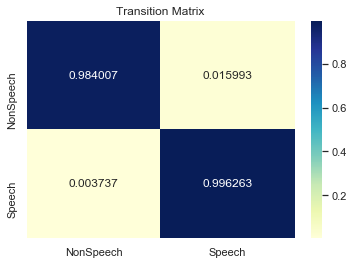

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

transition_matrix = np.asarray([[0.98400684 ,0.01599316],[0.00373748 ,0.99626252]])
Index= ['NonSpeech', 'Speech']
Cols = ['NonSpeech', 'Speech']
df = pd.DataFrame(data=transition_matrix,index=Index, columns=Cols)
sns.heatmap(df, annot=True, fmt="f",cmap="YlGnBu")
plt.title('Transition Matrix')
plt.savefig('Transition Matrix.png',dpi = 1000)

In [12]:

import muda
import os
import requests

print(os.getcwd())

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook


In [13]:
jams_path = "/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/union/IRConvolution/soundscape_train_bimodal1_deformed_00.jams"
audio_path = "/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/union/IRConvolution/soundscape_train_bimodal1_deformed_00.wav"
j_orig = muda.load_jam_audio(jams_path, audio_path)            
#mudabox = j_orig.sandbox.muda

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [1]:
import jams
j_orig = jams.load("/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/perturbations/union/IRConvolution/soundscape_train_bimodal1_deformed_00.jams")

AttributeError: '_io.TextIOWrapper' object has no attribute 'replace'

In [5]:
import jams
another_jam = jams.load("output_00.jams")#output_00.jams

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [4]:
another_jam

<JAMS(file_metadata=<FileMetadata(...)>,
      annotations=[1 annotation],
      sandbox=<Sandbox(...)>)>

In [6]:
import muda
j_orig = muda.load_jam_audio('soundscape_train_bimodal0_deformed_00.jams', 'soundscape_train_bimodal0_deformed_00.wav')


In [7]:
j_orig

<JAMS(file_metadata=<FileMetadata(...)>,
      annotations=[1 annotation],
      sandbox=<Sandbox(...)>)>